# Human Activity Recognition with Chestmounted Accelerometer

We will be analyzing the data with respect to all the subjects as we want to classify the activities in general and not be specific to the person.

The modelling for the data will be with respect to the sliding window functionality as the data samples are already sampled with 1 second window with 50% overlap. 
This approach will take into consideration the pre-activities that will be involved in the actions being taken by the person as a sequence and will help in making better recurrent neural networks models.

'Working at Computer', 'Standing Up, Walking and Going up\\down stairs', 'Standing', 'Walking', 'Going Up\\Down Stairs', 'Walking and Talking with Someone', 'Talking while Standing'



# Reading & Understanding the Data

In [1]:
import os
os.environ['PYTHONHASHSEED']=str(1)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style('whitegrid')
plt.style.use('seaborn-deep')
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.serif'] = 'Ubuntu'
plt.rcParams['font.monospace'] = 'Ubuntu Mono'
plt.rcParams['font.size'] = 10
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['axes.titlesize'] = 12
plt.rcParams['xtick.labelsize'] = 8
plt.rcParams['ytick.labelsize'] = 8
plt.rcParams['legend.fontsize'] = 12
plt.rcParams['figure.titlesize'] = 14
plt.rcParams['figure.figsize'] = (12, 8)

pd.options.mode.chained_assignment = None
pd.options.display.float_format = '{:.2f}'.format
pd.set_option('display.max_columns', 200)
pd.set_option('display.width', 400)
import warnings
warnings.filterwarnings('ignore')
from pprint import pprint
import sklearn.metrics as skm
import sklearn.model_selection as skms
import sklearn.ensemble as ske
import sklearn.preprocessing as skp
import random
seed = 12

In [2]:
import tensorflow as tf
from tensorflow import keras as k
print(tf.__version__)
from keras import backend as K
from keras.utils import to_categorical
import os, shutil, re, string
import matplotlib.pyplot as plt
seed=100

2.3.1


In [3]:
def set_seed(seed):
    os.environ['PYTHONHASHSEED']=str(seed)
    tf.random.set_seed(seed)
    np.random.seed(seed)
    random.seed(seed)

set_seed(seed)

In [4]:
# scanning data and merging with participant as person column for identification
DIR = '/kaggle/input/single-chestmounted-accelerometer/'
DIR = './data/'
df = pd.DataFrame()
for x in range(1,16):
    df_temp = pd.read_csv(os.path.join(DIR, str(x)+'.csv'))
    df_temp.columns = ['index','x','y','z','class']
    df_temp['person'] = x
    df_temp.drop('index', inplace=True, axis=1)
#     df_temp.drop(df_temp[df_temp['class'] == 0].index.tolist(), inplace=True, axis=0)
    df = pd.concat([df, df_temp], axis=0)

df = df.reset_index(drop=True)
print("Scanned",len(df.person.unique()),"participants recordings")
df.tail()

Scanned 15 participants recordings


,x,y,z,class,person
1926876,2043,2539,1990,7,15
1926877,2036,2508,1976,7,15
1926878,2025,2520,1991,7,15
1926879,2009,2546,2007,7,15
1926880,1999,2532,1996,0,15


In [5]:
# map index to label
index_label = dict()
index_label[0] = "None"
index_label[1] = "Working at Computer"
index_label[2] = "Standing Up, Walking and Going up\down stairs"
index_label[3] = "Standing"
index_label[4] = "Walking"
index_label[5] = "Going Up\Down Stairs"
index_label[6] = "Walking and Talking with Someone"
index_label[7] = "Talking while Standing"

index_label.values()

dict_values(['None', 'Working at Computer', 'Standing Up, Walking and Going up\\down stairs', 'Standing', 'Walking', 'Going Up\\Down Stairs', 'Walking and Talking with Someone', 'Talking while Standing'])

# Data Visualization

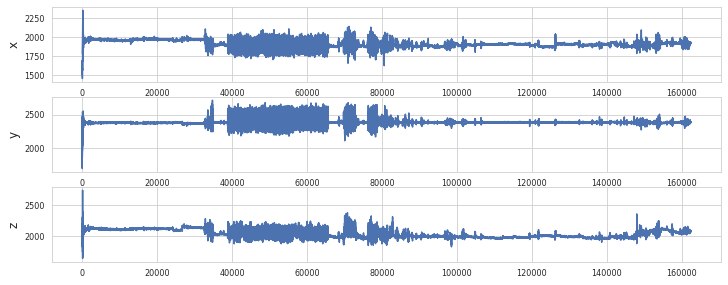

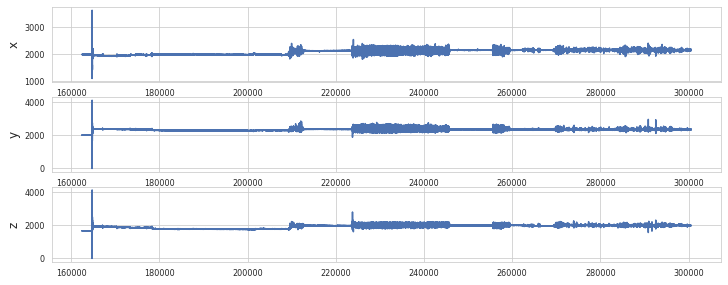

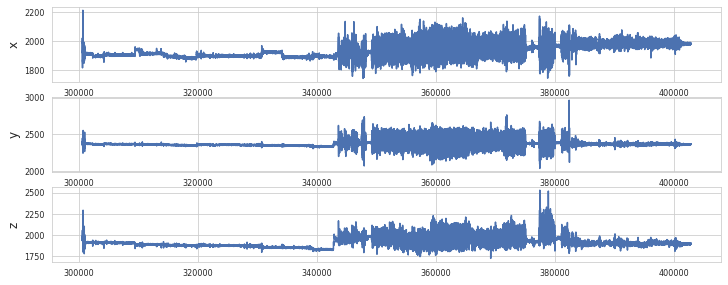

In [ ]:
# plot x, y, z acceleration
def plotXYZ(df_plot, p):
    plt.figure()
    for col in range(3):
        plt.subplot(df_plot.shape[1], 1, col+1)
        sns.lineplot(df_plot.index.tolist(), df_plot.iloc[:,col])
    plt.show()

for x in range(1,3):
    df_temp = df[df["person"]==x]
    plotXYZ(df_temp, x)

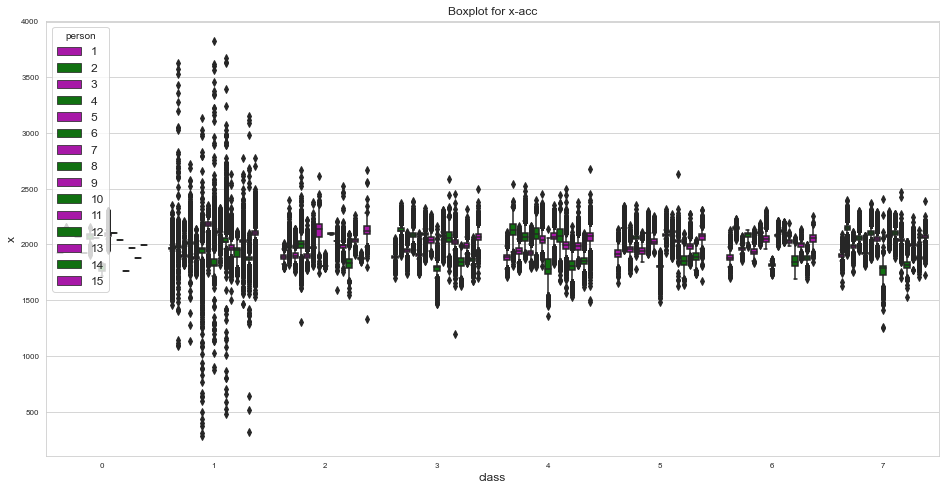

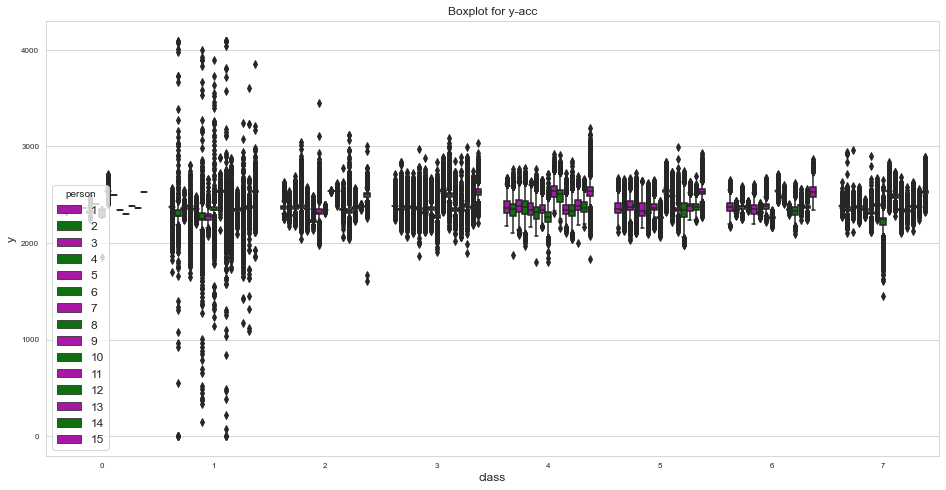

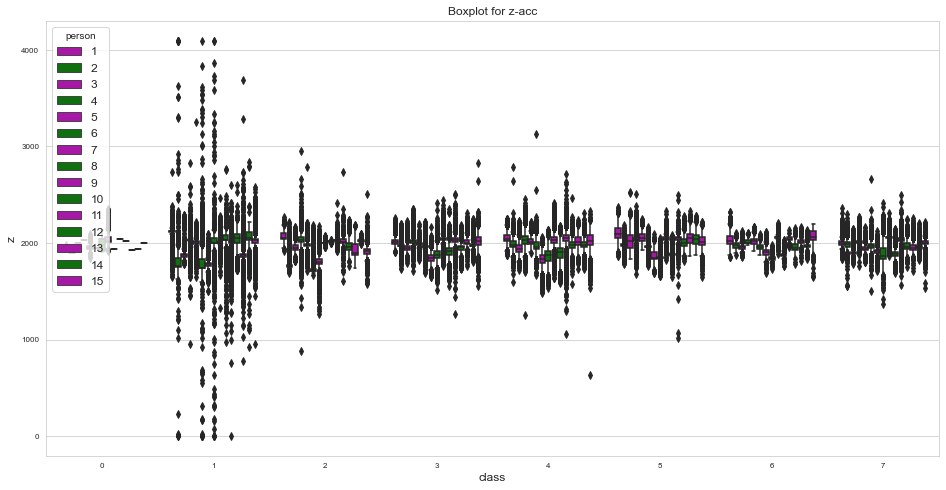

In [6]:
# plot boxplot for all classes
plt.figure(figsize=(16,8))
sns.boxplot(x="class", y="x",
            hue="person", palette=["m", "g"],
            data=df)
plt.title("Boxplot for x-acc")
plt.show()


plt.figure(figsize=(16,8))
sns.boxplot(x="class", y="y",
            hue="person", palette=["m", "g"],
            data=df)
plt.title("Boxplot for y-acc")
plt.show()


plt.figure(figsize=(16,8))
sns.boxplot(x="class", y="z",
            hue="person", palette=["m", "g"],
            data=df)
plt.title("Boxplot for z-acc")
plt.show()


There are outliers present in the data. Class 1 has most number of outliers present in it and need to be treated.

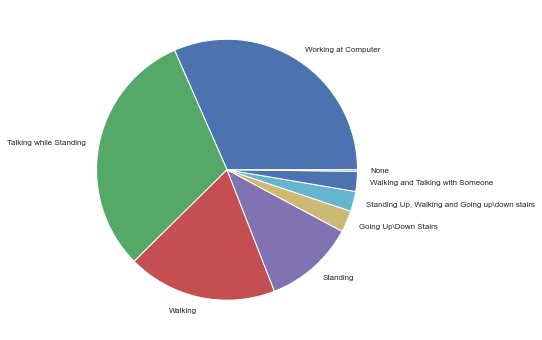

In [7]:
# checking distribution of samples against classes
plt.figure(figsize=(12,6))
plt.pie(df['class'].value_counts(), labels=[index_label[x] for x in df['class'].value_counts().index])
plt.show()

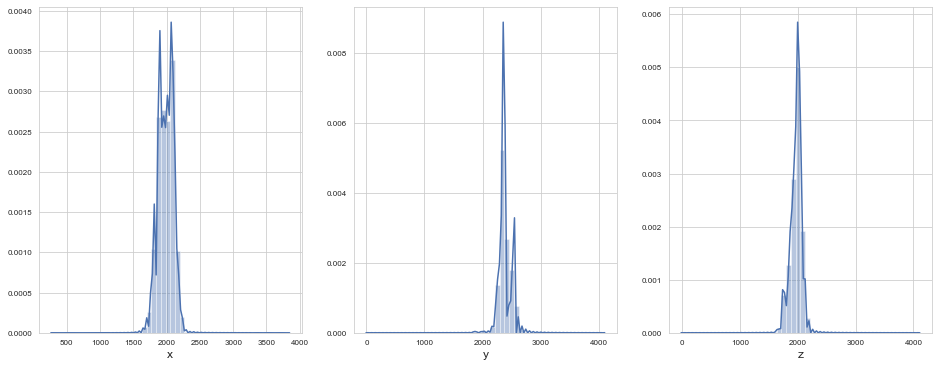

In [8]:
# checking distributions for x, y and z
plt.figure(figsize=(16,6))
plt.subplot(1,3,1)
sns.distplot(df['x'])

plt.subplot(1,3,2)
sns.distplot(df['y'])

plt.subplot(1,3,3)
sns.distplot(df['z'])
plt.show()

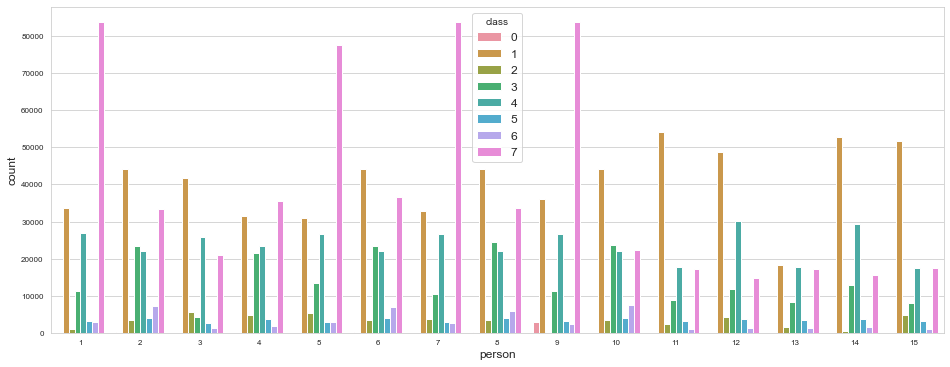

In [9]:
# countplot distribution for each person per class
plt.figure(figsize=(16,6))
sns.countplot(x='person', hue='class', data=df)
plt.show()

Data is highly imbalanced and needs to be treated well.

# Data Preparation

In [6]:
# remove multi-activities classes - 0, 2, and 6
df = df[~df["class"].isin([0,2,6])]
print("Remaining classes",df['class'].unique())

Remaining classes [1 3 4 5 7]


In [7]:
# replacing class 0, and 2 with 5 and 7 respectively.
# 0 => 5
# 2 => 7
df['class'] = [0 if x is 5 else 2 if x is 7 else x for x in df['class']]
df['class'].value_counts()

1    608652
2    593563
4    357064
3    216737
0     51498
Name: class, dtype: int64

In [8]:
# removing outliers, values away from mean +- x*sd, from all classes for x, y and z
indexesToRemove = []
for x in df['class'].unique().tolist():
    # filter with specific class
    print("Filtering class",x)
    df_temp = df[df['class'] == x]

    for y in range(3):
        # remove rows with values away from mean by 3SD, in x, y and z
        mean = df_temp.iloc[:,y].mean()
        sd = df_temp.iloc[:,y].std()
        away = 3
        upperlimit = mean + away * sd
        lowerlimit = mean - away * sd
        
        i = df_temp[(df_temp.iloc[:,y] > upperlimit) | (df_temp.iloc[:,y] < lowerlimit)].index.tolist()
        indexesToRemove.extend(i)

indexesToRemove = list(set(indexesToRemove))
df.drop(indexesToRemove, axis=0, inplace=True)
df.reset_index(drop=True, inplace=True)
print("Removed",len(indexesToRemove),"rows.")

Filtering class 1
Filtering class 3
Filtering class 4
Filtering class 0
Filtering class 2
Removed 26208 rows.


In [9]:
# checking distribution of x, y and z after removing outliers
df.describe()

,x,y,z,class,person
count,1801306.00,1801306.00,1801306.00,1801306.00,1801306.00
mean,1988.08,2385.07,1972.96,2.12,7.52
std,108.05,91.18,90.53,1.15,4.20
min,1605.00,2042.00,1596.00,0.00,1.00
25%,1905.00,2339.00,1920.00,1.00,4.00
50%,1992.00,2368.00,1990.00,2.00,7.00
75%,2075.00,2411.00,2033.00,3.00,11.00
max,2355.00,2731.00,2337.00,4.00,15.00


## Train-Test Split

In [10]:
# splitting by person recordings, first 12 for training and last 3 for test
X_train = df[df['person'] <= 12]
X_test = df[df['person'] > 12]
y_train = X_train.pop('class')
y_test = X_test.pop('class')
X_train.head()

,x,y,z,person
0,1726,2203,2005,1
1,1778,2143,1946,1
2,1718,2102,2012,1
3,1724,2101,2309,1
4,1706,2277,1986,1


In [11]:
# drop person column from both
X_train.drop('person', axis=1, inplace=True)
X_test.drop('person', axis=1, inplace=True)
X_train.head()

,x,y,z
0,1726,2203,2005
1,1778,2143,1946
2,1718,2102,2012
3,1724,2101,2309
4,1706,2277,1986


## Handle Class Imbalance

In [12]:
# generate training class weights which will be fed into model while training
from sklearn.utils import class_weight
weights = class_weight.compute_class_weight('balanced', np.unique(y_train), y_train)
train_class_weights = dict(zip(np.unique(y_train), weights))
pprint(train_class_weights)

{0: 7.487231643956475,
 1: 0.6378617749364245,
 2: 0.5714047914293676,
 3: 1.650944874656176,
 4: 1.0605410509287705}


## Scale Data

In [13]:
scaler = skp.MinMaxScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_test = pd.DataFrame(scaler.transform(X_test), columns=X_train.columns)

## Data Sampling

In [14]:
samples_per_sec = 52
window_seconds = 2
window_size = samples_per_sec * window_seconds

def sampleData(df, y):
    X_sampled = []
    y_sampled = []
    window = list(range(df.shape[0]))[::window_size]
    for x in range(len(window)-1):
        window_sample_X = df.iloc[window[x]:window[x+1],:].values.tolist()
        X_sampled.append(window_sample_X)
        
        window_sample_y = y.iloc[window[x]:window[x+1]].tolist()
        window_sample_y = max(window_sample_y, key=window_sample_y.count)
        y_sampled.append(window_sample_y)
        
    return np.array(X_sampled), np.array(y_sampled)

X_train_sampled, y_train_sampled = sampleData(X_train, y_train)
X_test_sampled, y_test_sampled = sampleData(X_test, y_test)

X_train_sampled.shape

(14687, 104, 3)

# Model Building

In [49]:
THRESHOLD = 0.9

class myCallback(k.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('val_sparse_categorical_accuracy') > THRESHOLD):
            print("\n\nStopping training as we have reached our goal.")   
            self.model.stop_training = True

callback = myCallback()

def plotHistory(history):
    print("Max. Val. Accuracy -",max(history.history['val_sparse_categorical_accuracy']),"for epoch",str(int(np.argmax(history.history['val_sparse_categorical_accuracy'])+1)))
    pd.DataFrame(history.history).plot(figsize=(12,6))
    plt.show()
    
    
import datetime    
curr_dt_time = datetime.datetime.now()

# !rm -rf /kaggle/working/
model_name = '/kaggle/working/model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)

filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{sparse_categorical_accuracy:.5f}-{val_loss:.5f}-{val_sparse_categorical_accuracy:.5f}.h5'

checkpoint = k.callbacks.ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

LR = k.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, verbose=1, patience=5)

callbacks_list = [checkpoint]
# callbacks_list.append(LR)

## Dense Layer Model

In [81]:
model = k.Sequential([
    
    k.layers.Dense(2048, activation='relu', input_shape=(X_train.shape[1],)),

    k.layers.Dense(1024, activation='relu'),
    k.layers.BatchNormalization(),

    k.layers.Dense(512, activation='relu'),
    k.layers.BatchNormalization(),
    k.layers.Dropout(0.2),

    k.layers.Dense(256, activation='relu'),
    k.layers.BatchNormalization(),
    k.layers.Dropout(0.2),

    k.layers.Dense(128, activation='relu'),
    k.layers.Dense(5)
])
model.summary()

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_54 (Dense)             (None, 2048)              8192      
_________________________________________________________________
dense_55 (Dense)             (None, 1024)              2098176   
_________________________________________________________________
batch_normalization_34 (Batc (None, 1024)              4096      
_________________________________________________________________
dense_56 (Dense)             (None, 512)               524800    
_________________________________________________________________
batch_normalization_35 (Batc (None, 512)               2048      
_________________________________________________________________
dropout_18 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_57 (Dense)             (None, 256)             

In [82]:
# compiling with RMSProp & Adam to find best
batch_size = 1024*16
epochs = 50
model.compile(
    optimizer=k.optimizers.Adam(),
    loss=k.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['sparse_categorical_accuracy']
)
set_seed(seed)
history = model.fit(
                    X_train, y_train, validation_data=(X_test, y_test), 
                    epochs=epochs, batch_size=batch_size, 
                    class_weight=train_class_weights
                    # callbacks=[callback]
                   )



Epoch 1/50
94/94 [==============================] - 6s 61ms/step - loss: 1.0622 - sparse_categorical_accuracy: 0.6514 - val_loss: 1.9754 - val_sparse_categorical_accuracy: 0.1746
Epoch 2/50
94/94 [==============================] - 6s 60ms/step - loss: 0.9046 - sparse_categorical_accuracy: 0.7120 - val_loss: 2.7001 - val_sparse_categorical_accuracy: 0.1152
Epoch 3/50
94/94 [==============================] - 6s 61ms/step - loss: 0.8666 - sparse_categorical_accuracy: 0.7277 - val_loss: 2.7442 - val_sparse_categorical_accuracy: 0.1286
Epoch 4/50
94/94 [==============================] - 6s 61ms/step - loss: 0.8468 - sparse_categorical_accuracy: 0.7356 - val_loss: 2.4642 - val_sparse_categorical_accuracy: 0.2405
Epoch 5/50
94/94 [==============================] - 6s 59ms/step - loss: 0.8323 - sparse_categorical_accuracy: 0.7406 - val_loss: 2.1652 - val_sparse_categorical_accuracy: 0.3019
Epoch 6/50
94/94 [==============================] - 6s 60ms/step - loss: 0.8241 - sparse_categorical_accu

Max. Val. Accuracy - 0.40359658002853394 for epoch 7


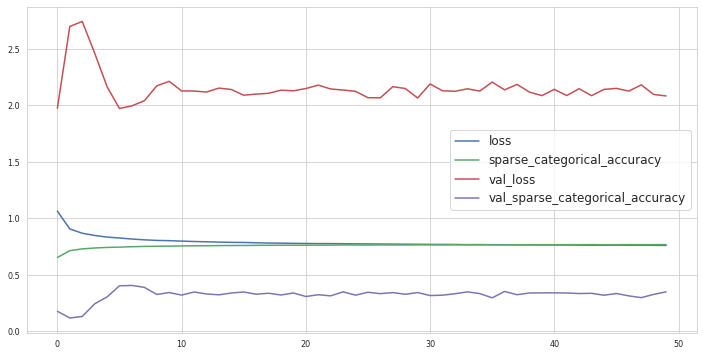

In [83]:
plotHistory(history)

Tried with different combinations of Dense layers but cannot get a good accuracy.

## Random Forest Model

In [32]:
rfc = ske.RandomForestClassifier(random_state=seed, class_weight=train_class_weights)
rfc.fit(X_train, y_train)
predictions = rfc.predict(X_test)
skm.accuracy_score(y_test, predictions)

0.37366169761215073

## Conv1D-GRU-LSTM Model Combinations

In [42]:
model = k.Sequential([
    
#     k.layers.Conv1D(filters=512, kernel_size=5, activation='relu', input_shape=(window_size,3)),

#     k.layers.Conv1D(filters=512, kernel_size=5, activation='relu'),
#     k.layers.Dropout(0.3),

#     k.layers.Conv1D(filters=256, kernel_size=5, activation='relu'),
#     k.layers.Dropout(0.4),

#     k.layers.Conv1D(filters=128, kernel_size=3, activation='relu'),
#     k.layers.Dropout(0.4),

#     k.layers.GlobalMaxPool1D(),
#     k.layers.Dropout(0.3),

#     k.layers.Bidirectional(k.layers.LSTM(512, return_sequences=True), input_shape=(window_size,3)),
#     k.layers.Dropout(0.2),

#     k.layers.Bidirectional(k.layers.LSTM(256, return_sequences=True)),
#     k.layers.Dropout(0.2),

#     k.layers.Bidirectional(k.layers.LSTM(128)),
#     k.layers.Dropout(0.2),

    k.layers.Bidirectional(k.layers.GRU(512, return_sequences=True), input_shape=(window_size,3)),
#     k.layers.BatchNormalization(),
    k.layers.Dropout(0.3),

    k.layers.Bidirectional(k.layers.GRU(256, return_sequences=True)),
#     k.layers.BatchNormalization(),
    k.layers.Dropout(0.3),

    k.layers.Bidirectional(k.layers.GRU(128)),
    k.layers.Dropout(0.3),

    k.layers.Flatten(),
    k.layers.Dense(128, activation='relu'),
    k.layers.Dense(5)
])
model.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_27 (Bidirectio (None, 104, 1024)         1588224   
_________________________________________________________________
dropout_30 (Dropout)         (None, 104, 1024)         0         
_________________________________________________________________
bidirectional_28 (Bidirectio (None, 104, 512)          1969152   
_________________________________________________________________
dropout_31 (Dropout)         (None, 104, 512)          0         
_________________________________________________________________
bidirectional_29 (Bidirectio (None, 256)               493056    
_________________________________________________________________
dropout_32 (Dropout)         (None, 256)               0         
_________________________________________________________________
flatten_10 (Flatten)         (None, 256)             

In [43]:
# compiling with RMSProp & Adam to find best
batch_size = 128
epochs = 30
model.compile(
    optimizer=k.optimizers.Adam(),
    loss=k.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['sparse_categorical_accuracy']
)
history = model.fit(
                    X_train_sampled, y_train_sampled, validation_data=(X_test_sampled, y_test_sampled), 
                    epochs=epochs, batch_size=batch_size, 
                    class_weight=train_class_weights,
                    callbacks=[callbacks_list]
                   )

Epoch 1/30
115/115 [==============================] - ETA: 0s - loss: 1.5799 - sparse_categorical_accuracy: 0.2604
Epoch 00001: saving model to /kaggle/working/model_init_2021-01-1013_02_37.500590/model-00001-1.57991-0.26043-1.44228-0.48328.h5
115/115 [==============================] - 16s 140ms/step - loss: 1.5799 - sparse_categorical_accuracy: 0.2604 - val_loss: 1.4423 - val_sparse_categorical_accuracy: 0.4833
Epoch 2/30
115/115 [==============================] - ETA: 0s - loss: 1.3017 - sparse_categorical_accuracy: 0.5009
Epoch 00002: saving model to /kaggle/working/model_init_2021-01-1013_02_37.500590/model-00002-1.30168-0.50092-1.15640-0.54369.h5
115/115 [==============================] - 14s 123ms/step - loss: 1.3017 - sparse_categorical_accuracy: 0.5009 - val_loss: 1.1564 - val_sparse_categorical_accuracy: 0.5437
Epoch 3/30
115/115 [==============================] - ETA: 0s - loss: 1.1104 - sparse_categorical_accuracy: 0.5935
Epoch 00003: saving model to /kaggle/working/model_in

Epoch 21/30
115/115 [==============================] - ETA: 0s - loss: 0.5379 - sparse_categorical_accuracy: 0.8141
Epoch 00021: saving model to /kaggle/working/model_init_2021-01-1013_02_37.500590/model-00021-0.53786-0.81405-1.60088-0.59726.h5
115/115 [==============================] - 14s 123ms/step - loss: 0.5379 - sparse_categorical_accuracy: 0.8141 - val_loss: 1.6009 - val_sparse_categorical_accuracy: 0.5973
Epoch 22/30
115/115 [==============================] - ETA: 0s - loss: 0.4863 - sparse_categorical_accuracy: 0.8322
Epoch 00022: saving model to /kaggle/working/model_init_2021-01-1013_02_37.500590/model-00022-0.48625-0.83223-1.81905-0.54939.h5
115/115 [==============================] - 14s 123ms/step - loss: 0.4863 - sparse_categorical_accuracy: 0.8322 - val_loss: 1.8191 - val_sparse_categorical_accuracy: 0.5494
Epoch 23/30
115/115 [==============================] - ETA: 0s - loss: 0.4639 - sparse_categorical_accuracy: 0.8379
Epoch 00023: saving model to /kaggle/working/model

Max. Val. Accuracy - 0.628039538860321 for epoch 14


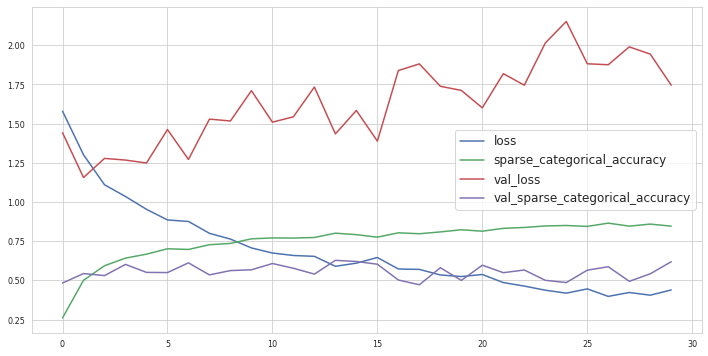

In [45]:
plotHistory(history)

In [46]:
model = k.models.load_model('/kaggle/working/model_init_2021-01-1013_02_37.500590/model-00014-0.59013-0.80132-1.43474-0.62804.h5')
loss, accuracy = model.evaluate(X_test_sampled, y_test_sampled, verbose=0)
print("Test Loss -",loss)
print("Test Accuracy -",accuracy)

y_test_pred = model.predict(X_test_sampled)
y_test_pred_class = [np.argmax(x) for x in y_test_pred]
print(skm.classification_report(y_test_sampled, y_test_pred_class))

Test Loss - 1.4347360134124756
Test Accuracy - 0.628039538860321
              precision    recall  f1-score   support

           0       0.11      0.18      0.14        98
           1       0.80      0.68      0.73      1173
           2       0.40      0.53      0.46       477
           3       0.31      0.21      0.25       271
           4       0.80      0.87      0.83       613

    accuracy                           0.63      2632
   macro avg       0.48      0.49      0.48      2632
weighted avg       0.65      0.63      0.63      2632



In [50]:
model = k.Sequential([
    
#     k.layers.Conv1D(filters=512, kernel_size=5, activation='relu', input_shape=(window_size,3)),

#     k.layers.Conv1D(filters=512, kernel_size=5, activation='relu'),
#     k.layers.Dropout(0.3),

#     k.layers.Conv1D(filters=256, kernel_size=5, activation='relu'),
#     k.layers.Dropout(0.4),

#     k.layers.Conv1D(filters=128, kernel_size=3, activation='relu'),
#     k.layers.Dropout(0.4),

#     k.layers.GlobalMaxPool1D(),
#     k.layers.Dropout(0.3),

    k.layers.Bidirectional(k.layers.LSTM(512, return_sequences=True), input_shape=(window_size,3)),
    k.layers.Dropout(0.3),

    k.layers.Bidirectional(k.layers.LSTM(256, return_sequences=True)),
    k.layers.Dropout(0.3),

    k.layers.Bidirectional(k.layers.LSTM(128)),
    k.layers.Dropout(0.3),

#     k.layers.Bidirectional(k.layers.GRU(512, return_sequences=True), input_shape=(window_size,3)),
#     k.layers.BatchNormalization(),
#     k.layers.Dropout(0.3),

#     k.layers.Bidirectional(k.layers.GRU(256, return_sequences=True)),
#     k.layers.BatchNormalization(),
#     k.layers.Dropout(0.3),

#     k.layers.Bidirectional(k.layers.GRU(128)),
#     k.layers.Dropout(0.3),

    k.layers.Flatten(),
    k.layers.Dense(128, activation='relu'),
    k.layers.Dense(5)
])
model.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_30 (Bidirectio (None, 104, 1024)         2113536   
_________________________________________________________________
dropout_33 (Dropout)         (None, 104, 1024)         0         
_________________________________________________________________
bidirectional_31 (Bidirectio (None, 104, 512)          2623488   
_________________________________________________________________
dropout_34 (Dropout)         (None, 104, 512)          0         
_________________________________________________________________
bidirectional_32 (Bidirectio (None, 256)               656384    
_________________________________________________________________
dropout_35 (Dropout)         (None, 256)               0         
_________________________________________________________________
flatten_11 (Flatten)         (None, 256)             

In [51]:
# compiling with RMSProp & Adam to find best
batch_size = 128
epochs = 40
model.compile(
    optimizer=k.optimizers.Adam(),
    loss=k.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['sparse_categorical_accuracy']
)
history = model.fit(
                    X_train_sampled, y_train_sampled, validation_data=(X_test_sampled, y_test_sampled), 
                    epochs=epochs, batch_size=batch_size, 
                    class_weight=train_class_weights,
                    callbacks=[callbacks_list]
                   )

Epoch 1/40
115/115 [==============================] - ETA: 0s - loss: 1.5903 - sparse_categorical_accuracy: 0.2337
Epoch 00001: saving model to /kaggle/working/model_init_2021-01-1013_18_26.433480/model-00001-1.59034-0.23368-1.53808-0.39742.h5
115/115 [==============================] - 18s 157ms/step - loss: 1.5903 - sparse_categorical_accuracy: 0.2337 - val_loss: 1.5381 - val_sparse_categorical_accuracy: 0.3974
Epoch 2/40
115/115 [==============================] - ETA: 0s - loss: 1.4315 - sparse_categorical_accuracy: 0.4185
Epoch 00002: saving model to /kaggle/working/model_init_2021-01-1013_18_26.433480/model-00002-1.43149-0.41847-1.16283-0.59840.h5
115/115 [==============================] - 16s 141ms/step - loss: 1.4315 - sparse_categorical_accuracy: 0.4185 - val_loss: 1.1628 - val_sparse_categorical_accuracy: 0.5984
Epoch 3/40
115/115 [==============================] - ETA: 0s - loss: 1.1694 - sparse_categorical_accuracy: 0.5589
Epoch 00003: saving model to /kaggle/working/model_in

Epoch 21/40
115/115 [==============================] - ETA: 0s - loss: 0.6692 - sparse_categorical_accuracy: 0.7664
Epoch 00021: saving model to /kaggle/working/model_init_2021-01-1013_18_26.433480/model-00021-0.66916-0.76639-1.88875-0.44453.h5
115/115 [==============================] - 16s 141ms/step - loss: 0.6692 - sparse_categorical_accuracy: 0.7664 - val_loss: 1.8888 - val_sparse_categorical_accuracy: 0.4445
Epoch 22/40
115/115 [==============================] - ETA: 0s - loss: 0.7260 - sparse_categorical_accuracy: 0.7473
Epoch 00022: saving model to /kaggle/working/model_init_2021-01-1013_18_26.433480/model-00022-0.72601-0.74733-1.50703-0.57903.h5
115/115 [==============================] - 16s 141ms/step - loss: 0.7260 - sparse_categorical_accuracy: 0.7473 - val_loss: 1.5070 - val_sparse_categorical_accuracy: 0.5790
Epoch 23/40
115/115 [==============================] - ETA: 0s - loss: 0.6215 - sparse_categorical_accuracy: 0.7773
Epoch 00023: saving model to /kaggle/working/model

Max. Val. Accuracy - 0.646276593208313 for epoch 12


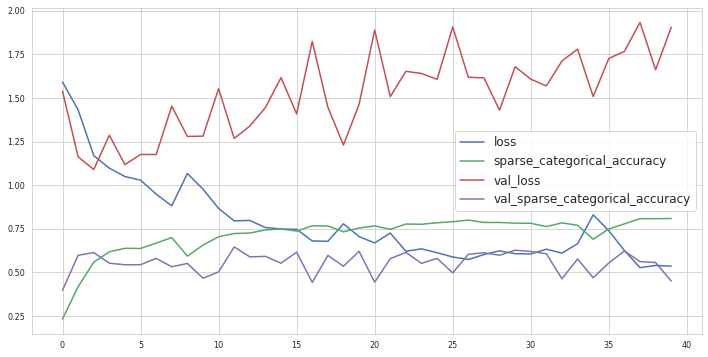

In [52]:
plotHistory(history)

In [53]:
model = k.models.load_model('/kaggle/working/model_init_2021-01-1013_18_26.433480/model-00012-0.79554-0.72309-1.26758-0.64628.h5')
loss, accuracy = model.evaluate(X_test_sampled, y_test_sampled, verbose=0)
print("Test Loss -",loss)
print("Test Accuracy -",accuracy)

y_test_pred = model.predict(X_test_sampled)
y_test_pred_class = [np.argmax(x) for x in y_test_pred]
print(skm.classification_report(y_test_sampled, y_test_pred_class))

Test Loss - 1.2675845623016357
Test Accuracy - 0.646276593208313
              precision    recall  f1-score   support

           0       0.23      0.35      0.27        98
           1       0.75      0.71      0.73      1173
           2       0.48      0.57      0.52       477
           3       0.25      0.17      0.21       271
           4       0.82      0.83      0.83       613

    accuracy                           0.65      2632
   macro avg       0.51      0.53      0.51      2632
weighted avg       0.65      0.65      0.65      2632



# Approach

## Data Visualization

- line plots for x, y and z for each person to check sample distribution
- box plots for x, y and z for each class to check the outliers
- pie chart for distribution of classes in total
- distplots for x, y and z for gaussian distributions
- countplot for each class per person to check class imbalance

## Data Preparation

- Remove classes with multi-activities that will help in fairer evaluation of the activities which are 0, 2, & 6.
- Train Test Split with first 12 person for training and last 3 person for testing
- Outlier Detection will be applied (values > 3 times SD away from mean should be removed).
- Handle class imbalance problem in data by calculating class weights and setting them while model training.
- Scale the overall data to improve model training.
- Implemented multiple window sizes like 1, 2, 5 seconds to ensure what gives best result.


## Data Modeling

- Modeled with Dense layers of different combination with class weights but couldn't achieve good results.
- Modeled with RandomForest Classifier with class weights but couldn't achieve better results.
- Modeled with different combinations of Conv1D, GRUs, and LSTMs with Dropout and BatchNormalization between the layers with class weights but still could achieve around 64.62% of test accuracy and 65% of recall score.

`Final Result: 3 layer LSTM model with Adam optimizer, with 65% recall rate due to class imabalnce issue which can be seen with recall for specific classes with less samples. These results could be achieved with class weights calculated and can be more improved with generating more augmented data.`

## Future Work

- Must try oversampling and undersampling of samples for selected classes.